https://github.com/sgugger/Adam-experiments

In [1]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True
PATH = Path("../data/cifar10")

In [2]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [3]:
sz = 32
bs = 128

m = wrn_22()
base_lr = 3e-3
lr_div = 10
wd = 0.1
cyc_len = 18     # lenght of the cycle expressed in epochs
ann_len = 0.075   # length of the annealing phase expressed as a fraction of cycle_len

moms = (0.95,0.85)
beta2=0.99

phase_lengths = [cyc_len * (1-ann_len) / 2, cyc_len * (1-ann_len) / 2, cyc_len * ann_len]; phase_lengths

[8.325000000000001, 8.325000000000001, 1.3499999999999999]

In [4]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]

In [6]:
def adam(params): return optim.Adam(params, betas=(moms[0], beta2))
learn.opt_fn = adam

In [7]:
training_phases = [
    TrainingPhase(phase_lengths[0], adam, lr=(base_lr/lr_div, base_lr), lr_decay=DecayType.LINEAR,
              momentum=moms, wds=wd, wd_loss=False),
    TrainingPhase(phase_lengths[1], adam, lr=(base_lr, base_lr/lr_div), lr_decay=DecayType.LINEAR,
              momentum=(moms[1], moms[0]), wds=wd, wd_loss=False),
    TrainingPhase(phase_lengths[2], adam, lr=(base_lr/lr_div, base_lr/(lr_div*100)), lr_decay=DecayType.LINEAR,
              momentum=moms[0], wds=wd, wd_loss=False)
]

In [8]:
%time learn.fit_opt_sched(training_phases)

epoch      trn_loss   val_loss   accuracy                   
    0      1.100184   1.303615   0.5538    
    1      0.860301   0.829979   0.7096                      
    2      0.707362   0.658548   0.77                        
    3      0.601992   0.701045   0.7623                      
    4      0.552413   0.6147     0.7933                      
    5      0.4985     0.520587   0.8248                      
    6      0.461927   0.560585   0.8161                      
    7      0.44654    0.53767    0.8208                      
    8      0.396705   0.509707   0.8284                      
    9      0.355116   0.481006   0.8438                      
    10     0.305154   0.406727   0.8629                      
    11     0.262299   0.367325   0.8763                      
    12     0.220301   0.292306   0.9022                      
    13     0.17784    0.285621   0.9061                      
    14     0.146109   0.277172   0.9112                      
    15     0.109799   0.237

[array([0.21264]), 0.9375]

In [9]:
preds, targs = learn.TTA()
probs = np.exp(preds)/np.exp(preds).sum(2)[:,:,None]
probs = np.mean(probs,0)
acc = learn.metrics[0](V(probs), V(targs)).data[0]
loss = learn.crit(V(np.log(probs)), V(targs)).data[0]
f'Final loss: {loss}, Final accuracy: {acc}'

'Final loss: 0.1821363866329193, Final accuracy: 0.9420999884605408'

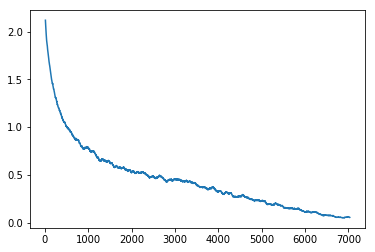

In [10]:
learn.sched.plot_loss()

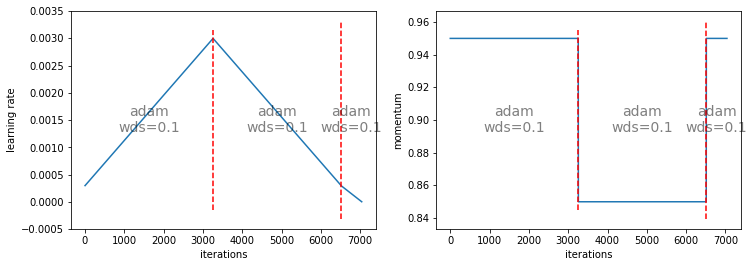

In [11]:
learn.sched.plot_lr()